<a href="https://colab.research.google.com/github/nisaruj/Chemception-plus/blob/master/Chemception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

### Install packages

In [ ]:
!pip install pubchempy

  Created wheel for pubchempy: filename=PubChemPy-1.0.4-cp36-none-any.whl size=13826 sha256=55a063422ff0a0a5e4bca914abb57644b9e4f6d5ca7e6bac89988ec7b6ad44be
  Stored in directory: /root/.cache/pip/wheels/10/4d/51/6b843681a9a5aef35f0d0fbce243de46f85080036e16118752
Successfully built pubchempy


In [ ]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local 
!time conda install -q -y -c conda-forge rdkit

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-09-24 14:56:15--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2020-09-24 14:56:16--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88867207 (85M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.3-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  84.75M   175MB/s    in 0.5s    

2020-09-24 14:56:16 (175 MB/s) - ‘Minicon

### Import mapping data

In [ ]:
!cp drive/My\ Drive/BIOINFO/nsc_smiles.pickle ./nsc_smiles.pickle

### Import dataset

In [ ]:
!cp drive/My\ Drive/BIOINFO/aids_conc_may04.txt ./dataset.csv

In [ ]:
# Trim whitespaces from dataset file
!sed -r "s/[ \t]//g" dataset.csv > out.csv
!mv out.csv dataset.csv

## Preprocess

CNN requires 2D matrix so we need to convert NSC id -> -> SMILES -> 2D grid image

### Preprocess dataset

* CA - Confirmed active
* CM - Confirmed moderately active
* CI - Confirmed inactive

In [ ]:
import pandas as pd

data = pd.read_csv("dataset.csv")
data.head(5)

,NSC,Conclusion
0,48,CI
1,78,CI
2,128,CI
3,163,CI
4,164,CI


We use NSC dataset which uses an internal id to identify a molecule so we need to create a mapping that converts NSC id to SMILES.

We can use PubChem api to retrieve smiles from NSC id

In [ ]:
import pubchempy as pcp
pcp.get_properties(['IsomericSMILES', 'CanonicalSMILES'], 'NSC170', 'name')

[{'CID': 219201,
  'CanonicalSMILES': 'CCOP(=O)(NC1=CC(=CC=C1)Cl)OCC',
  'IsomericSMILES': 'CCOP(=O)(NC1=CC(=CC=C1)Cl)OCC'}]

In [ ]:
# from progressbar import progressbar

# NSC2SMILES = {}
# start_from = 722245
# for compound_id in progressbar(data['NSC']):
#   if compound_id in NSC2SMILES:
#     continue
#   if compound_id < start_from:
#     continue
#   props = pcp.get_properties(['IsomericSMILES', 'CanonicalSMILES'], 'NSC' + str(compound_id), 'name')
#   if len(props) > 0:
#     NSC2SMILES[compound_id] = props[0]

In [ ]:
# import pickle

# with open('nsc_smiles.pickle', 'wb') as handle:
#     pickle.dump(NSC2SMILES, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle

with open('nsc_smiles.pickle', 'rb') as fp:
  NSC2SMILES = pickle.load(fp)
  
len(NSC2SMILES)

42407

In [ ]:
NSC2SMILES[7816]

{'CID': 73120,
 'CanonicalSMILES': 'C1=CC=C2C(=C1)C(OS2(=O)=O)(C3=CC(=C(C(=C3)Br)O)Cl)C4=CC(=C(C(=C4)Br)O)Cl',
 'IsomericSMILES': 'C1=CC=C2C(=C1)C(OS2(=O)=O)(C3=CC(=C(C(=C3)Br)O)Cl)C4=CC(=C(C(=C4)Br)O)Cl'}

We remove the data that isn't compound (ie. substance).

In [ ]:
data['is_compound'] = data['NSC'].isin(NSC2SMILES)
data = data[data['is_compound'] == True]

Like the paper, we reduce the problem to binary classification by setting CI to 0 and CM/CA to 1.

In [ ]:
data['active'] = data['Conclusion'].isin(['CM', 'CA'])
data.head(5)

,NSC,Conclusion,is_compound,active
2,128,CI,True,False
3,163,CI,True,False
4,164,CI,True,False
5,170,CI,True,False
6,180,CI,True,False


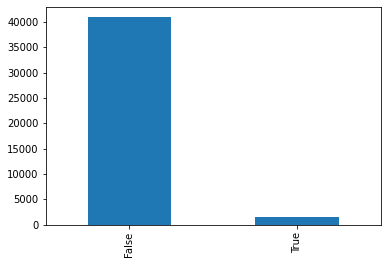

In [ ]:
data['active'].value_counts().plot(kind='bar');

### Chemcepterize NSC compound

`chemcepterizeFromNsc` converts a molecule into a color-coded grid image.

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def molFromNsc(nsc):
  return Chem.MolFromSmiles(NSC2SMILES[nsc]['IsomericSMILES'])

def drawFromNsc(nsc):
  Draw.MolToMPL(molFromNsc(nsc), size=(100, 100))

'''
https://www.cheminformania.com/learn-how-to-teach-your-computer-to-see-chemistry-free-chemception-models-with-rdkit-and-keras/
Note that the code above uses 4 channel image but the paper uses only 1 channel (greyscale).
We'll use 4 channel anyway.

@param embed
@param res - Resolution of each pixel (Å)
'''
def chemcepterizeFromNsc(nsc, embed=20.0, res=0.5):
    mol = molFromNsc(nsc)
    dims = int(embed*2/res)
    cmol = Chem.Mol(mol.ToBinary())
    cmol.ComputeGasteigerCharges()
    Chem.AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    vect = np.zeros((dims,dims,4))
    #Bonds first
    for i,bond in enumerate(mol.GetBonds()):
        bondorder = bond.GetBondTypeAsDouble()
        bidx = bond.GetBeginAtomIdx()
        eidx = bond.GetEndAtomIdx()
        bcoords = coords[bidx]
        ecoords = coords[eidx]
        frac = np.linspace(0,1,int(1/res*2))
        for f in frac:
            c = (f*bcoords + (1-f)*ecoords)
            idx = int(round((c[0] + embed)/res))
            idy = int(round((c[1]+ embed)/res))
            #Save in the vector first channel
            vect[ idx , idy ,0] = bondorder
    #Atom Layers
    for i,atom in enumerate(cmol.GetAtoms()):
            idx = int(round((coords[i][0] + embed)/res))
            idy = int(round((coords[i][1]+ embed)/res))
            #Atomic number
            vect[ idx , idy, 1] = atom.GetAtomicNum()
            #Gasteiger Charges
            charge = atom.GetProp("_GasteigerCharge")
            vect[ idx , idy, 3] = charge
            #Hybridization
            hyptype = atom.GetHybridization().real
            vect[ idx , idy, 2] = hyptype
    return vect

def drawChemceptionVector(v):
  plt.imshow(v[:,:,:3])

def drawChemceptionFromNsc(nsc, embed=20.0, res=0.5):
  v = chemcepterizeFromNsc(nsc, embed=embed, res=res)
  drawChemceptionVector(v)

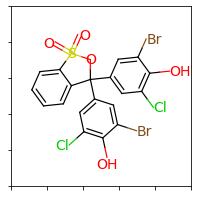

In [ ]:
drawFromNsc(7816)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


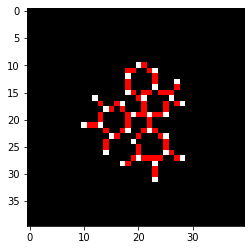

In [ ]:
drawChemceptionFromNsc(7816, embed=10)